### Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
sns.set_theme(style='ticks', font_scale=1)

import mlflow
from scipy.io import arff
from scipy.stats import skew, norm, boxcox_normmax, zscore
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from pathlib import Path
Root = Path('.').absolute().parent
DATA = Root/ r'C:\Users\Admin\Projects\ML Projects\bankruptcy_prediction\data'

In [1]:
x = [1000, 100, 1000, 10, 100, 1, 5]
x.pop(0)
print(x)

[100, 1000, 10, 100, 1, 5]


### EDA

In [ ]:
# arff_file = arff.loadarff(DATA/'1year.arff')
df = pd.read_csv(DATA/'data.csv')
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A57,A58,A59,A60,A61,A62,A63,A64,class,year
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,1
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,1
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,1
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,1
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      43397 non-null  float64
 1   A2      43397 non-null  float64
 2   A3      43397 non-null  float64
 3   A4      43271 non-null  float64
 4   A5      43316 non-null  float64
 5   A6      43397 non-null  float64
 6   A7      43397 non-null  float64
 7   A8      43311 non-null  float64
 8   A9      43396 non-null  float64
 9   A10     43397 non-null  float64
 10  A11     43361 non-null  float64
 11  A12     43271 non-null  float64
 12  A13     43278 non-null  float64
 13  A14     43397 non-null  float64
 14  A15     43369 non-null  float64
 15  A16     43310 non-null  float64
 16  A17     43311 non-null  float64
 17  A18     43397 non-null  float64
 18  A19     43277 non-null  float64
 19  A20     43278 non-null  float64
 20  A21     37551 non-null  float64
 21  A22     43397 non-null  float64
 22

In [ ]:
# Check for missing values
# print(f"\nMissing values: {df.isnull().sum()}")
# Checking Nan presence

df.isna().sum()
# [print(col) for col in df if df[col].isna().sum() > 0]

A1         8
A2         8
A3         8
A4       134
A5        89
        ... 
A62      127
A63      134
A64      812
class      0
year       0
Length: 66, dtype: int64

#### Prepare the data

In [ ]:
X = df.drop(columns=['class','year'])
y = df['class']

8

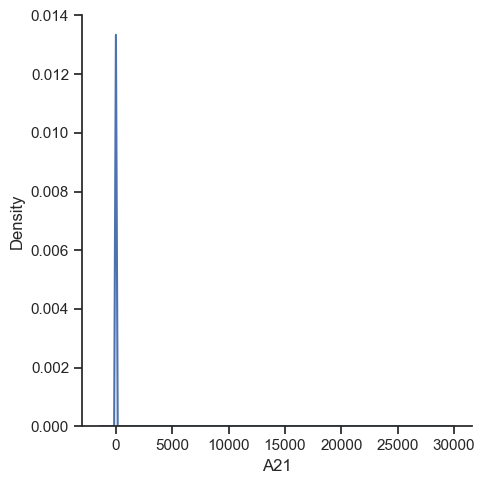

In [ ]:
sns.displot(df, x='A21', kind='kde')
# sns.boxplot(data=X, x='A20')
X['A1'].isna().sum()
# df['A20'].describe()

By looking at the plot the distribution of the features have outliers. There are several discussion for the order of Standardization and Fill, but we will follow StF.

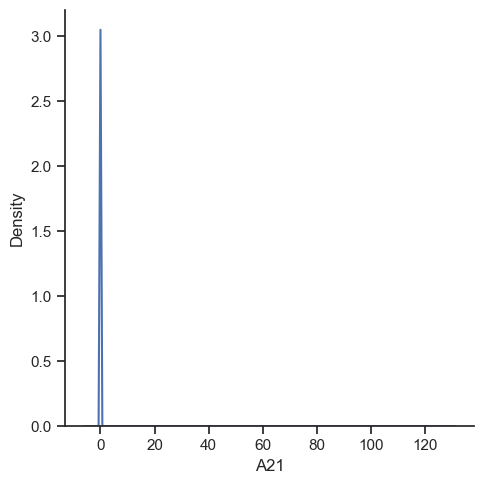

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled, columns=X.columns)
# sns.boxplot(data=X_scaled, x='A1')
sns.displot(X_scaled, x='A21', kind='kde')

Now we can deal with data with much smaller values

#### Missing values

In [ ]:
X_scaled.isna().sum().sort_values(ascending=False)

A37    18984
A21     5854
A27     2764
A60     2152
A45     2147
       ...  
A35        8
A1         8
A57        7
A59        7
A55        1
Length: 64, dtype: int64

In [ ]:
total = X_scaled.isna().sum().sort_values(ascending=False)
percent = X_scaled.isna().sum()/X_scaled.isna().count().sort_values(ascending=False) * 100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent %'])
missing_data.head(20)

,Total,Percent %
A37,18984,43.736897
A21,5854,13.486925
A27,2764,6.367930
A60,2152,4.957954
A45,2147,4.946435
A24,922,2.124179
A28,812,1.870752
A64,812,1.870752
A53,812,1.870752
A54,812,1.870752


As a general rule of thumb we can drop the columns with missing data more than 5%

In [ ]:
columns_to_drop = ['A37', 'A21', 'A27']
X_scaled = X_scaled.drop(columns_to_drop, axis=1)

We will impute the remaining missing rows with the mean

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_scaled)
X_imputed.shape

(43405, 61)

In [ ]:
# The classes are heavily skewed we need to solve this issue later.

print(df['class'].value_counts())
print('-'* 30)
print('Financially stable: ', round(df['class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Financially unstable: ', round(df['class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

class
0    41314
1     2091
Name: count, dtype: int64
------------------------------
Financially stable:  95.18 % of the dataset
Financially unstable:  4.82 % of the dataset


In [ ]:
df['class'].value_counts()

class
0    41314
1     2091
Name: count, dtype: int64

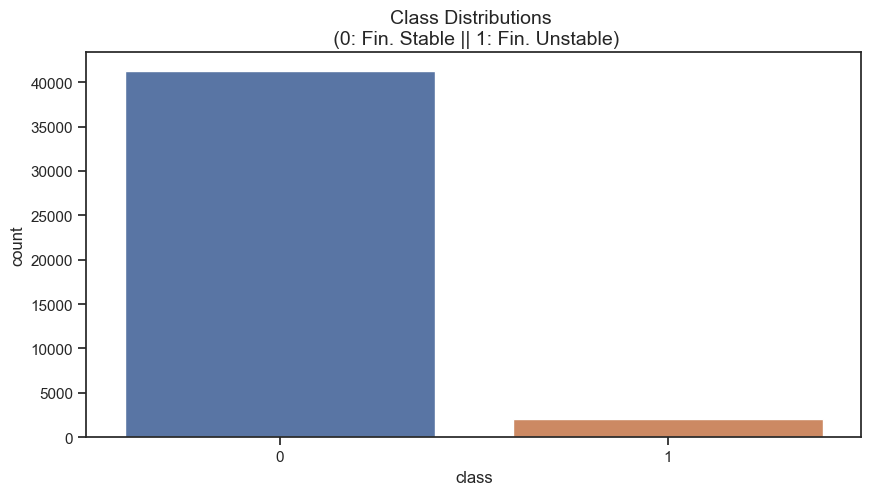

In [ ]:
# Checking labels distributions

plt.figure(figsize = (10,5))
sns.countplot(df, x='class', hue='class', legend=False)
plt.title('Class Distributions \n (0: Fin. Stable || 1: Fin. Unstable)', fontsize=14)
plt.show()

#### Outliers removal

In [ ]:
# Outliers removal

def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))
    #print(feature_name + ' outliers:{}'.format(outliers))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset

In [ ]:
# Using z-score to remove outliers
z_scores = zscore(df)

outlier_threshold = 3.0 # Set a threshold for identifying outliers
outliers_mask = np.abs(z_scores) > outlier_threshold

[Text(0.5, 1.0, 'Numeric Distribution of Features')]

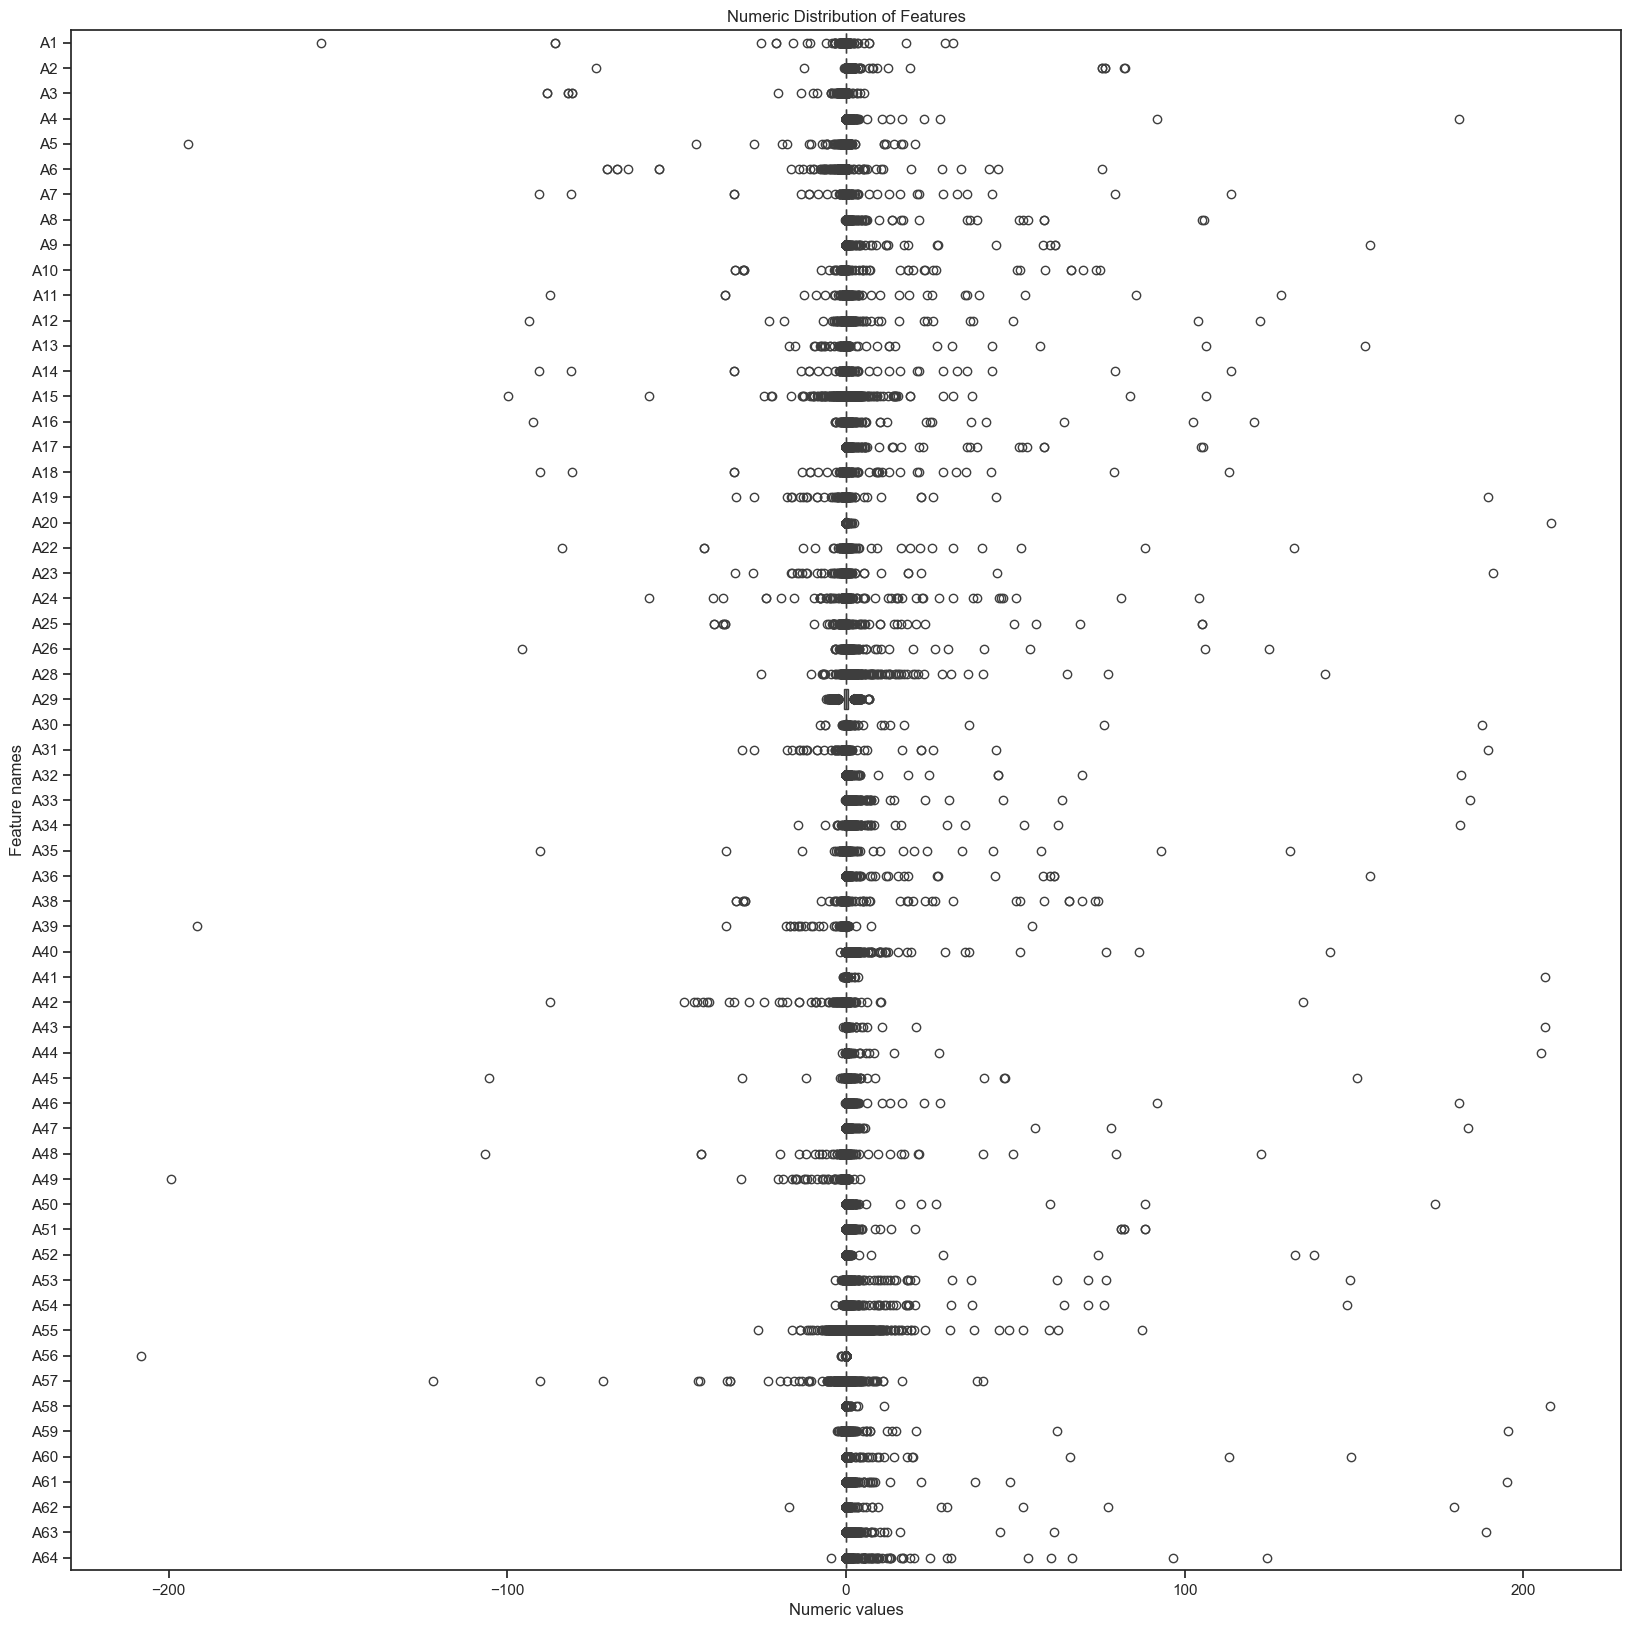

In [ ]:
# Create box plots for all numeric features
f, ax = plt.subplots(figsize=(20, 20))
# ax.set_xscale("log")
ax = sns.boxplot(data=X_scaled[X_scaled.columns] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")

In [ ]:
for col in X_scaled:
    new_X_scaled = outliers_removal(X_scaled[col],str(col),X_scaled)

Quartile 25: nan | Quartile 75: nan
iqr: nan
Cut Off: nan
A1 Lower: nan
A1 Upper: nan
A1 outliers for close to bankruptcy cases: 0
-----------------------------------------------------------------
Quartile 25: nan | Quartile 75: nan
iqr: nan
Cut Off: nan
A2 Lower: nan
A2 Upper: nan
A2 outliers for close to bankruptcy cases: 0
-----------------------------------------------------------------
Quartile 25: nan | Quartile 75: nan
iqr: nan
Cut Off: nan
A3 Lower: nan
A3 Upper: nan
A3 outliers for close to bankruptcy cases: 0
-----------------------------------------------------------------
Quartile 25: nan | Quartile 75: nan
iqr: nan
Cut Off: nan
A4 Lower: nan
A4 Upper: nan
A4 outliers for close to bankruptcy cases: 0
-----------------------------------------------------------------
Quartile 25: nan | Quartile 75: nan
iqr: nan
Cut Off: nan
A5 Lower: nan
A5 Upper: nan
A5 outliers for close to bankruptcy cases: 0
-----------------------------------------------------------------
Quartile 25: na